In [2]:
import os
from tqdm import tqdm 
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# DATA 

In [3]:
stops=pd.read_csv('/kaggle/input/porcodiooo/stops.csv')
stops = stops[
    (stops['LATITUDE'] >= 49.9) & (stops['LATITUDE'] <= 55.8) &
    (stops['LONGITUDE'] >= -6.4) & (stops['LONGITUDE'] <= 1.8) & (stops['DURATION']>5)
]

ports=pd.read_csv('/kaggle/input/tutti-i-porti/PORTS.csv')
ports = ports[
    (ports['LATITUDE'] >= 49.9) & (ports['LATITUDE'] <= 55.8) &
    (ports['LONGITUDE'] >= -6.4) & (ports['LONGITUDE'] <= 1.8)
]

# CLUSTERING

In [4]:
X = stops[['LONGITUDE', 'LATITUDE', 'DURATION']].copy()

# Applica DBSCAN a tutto il dataset
dbscan = DBSCAN(eps=0.05, min_samples=10)  # Puoi ottimizzare eps e min_samples
clusters = dbscan.fit_predict(X[['LONGITUDE', 'LATITUDE']])

# Aggiungi i risultati del clustering al dataset originale
stops['cluster'] = clusters

# PLOT

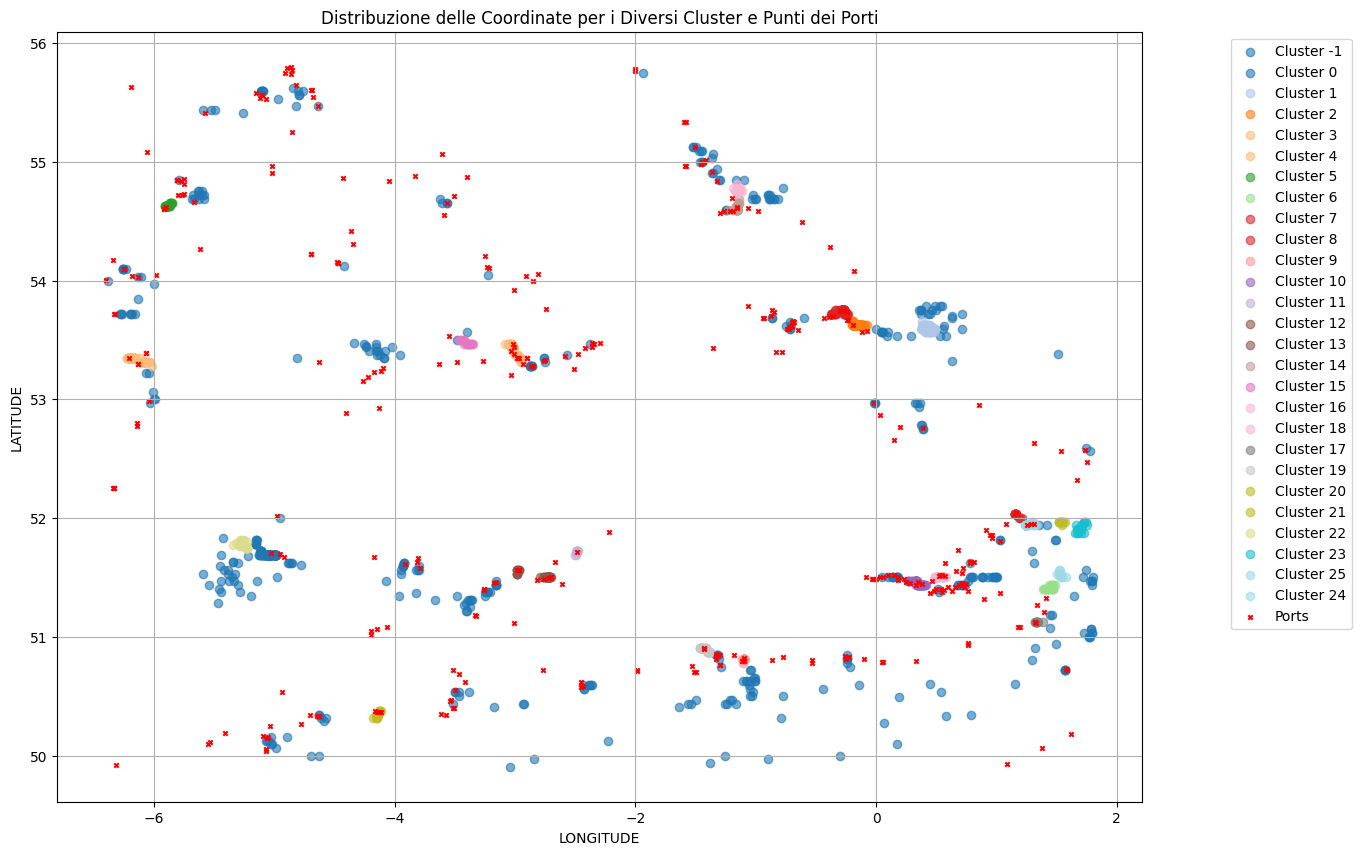

In [5]:


# Supponiamo che tu abbia già il DataFrame 'stops'
clusters = stops['cluster'].unique()

# Usa una mappa di colori da Matplotlib
cmap = plt.get_cmap('tab20', len(clusters))  # 'tab20' è una mappa di colori di base, ma la puoi ampliare con len(clusters)

# Imposta la figura per il grafico
plt.figure(figsize=(14, 10))

# Crea un grafico per ogni cluster
for i, cluster in enumerate(clusters):
    cluster_data = stops[stops['cluster'] == cluster]
    plt.scatter(cluster_data['LONGITUDE'], cluster_data['LATITUDE'], 
                c=[cmap(i)], 
                label=f'Cluster {cluster}', 
                alpha=0.6)

# Aggiungi i punti dei porti
plt.scatter(ports['LONGITUDE'], ports['LATITUDE'], 
            c='red', 
            marker='x', 
            s=10, 
            label='Ports')

# Aggiungi le etichette e il titolo
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.title('Distribuzione delle Coordinate per i Diversi Cluster e Punti dei Porti')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()


# EXPORT

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import os

# Dati d'esempio (sostituisci con il tuo DataFrame 'stops')
# stops = pd.DataFrame({
#     'LONGITUDE': [12.5, 13.5],
#     'LATITUDE': [41.9, 42.9],
#     'STOP_NAME': ['Stop1', 'Stop2']
# })

# Crea la geometria (punti) usando latitudine e longitudine
geometry = [Point(xy) for xy in zip(stops['LONGITUDE'], stops['LATITUDE'])]
gdf = gpd.GeoDataFrame(stops, geometry=geometry)

# Imposta il sistema di riferimento (CRS)
gdf.crs = "EPSG:4326"  # WGS 84

# Crea una cartella per i file di output
output_folder = "shapefile_output"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Esporta il GeoDataFrame come shapefile
output_path = os.path.join(output_folder, "output_shapefile.shp")
gdf.to_file(output_path)

print(f"Shapefile salvato nella cartella: {output_folder}")


# CENTROIDI

In [ ]:

# Trova il centroide per ogni cluster
centroids = stops.groupby('cluster')[['LONGITUDE', 'LATITUDE']].mean().reset_index()
centroids.rename(columns={'LONGITUDE': 'CENTROID_LONGITUDE', 'LATITUDE': 'CENTROID_LATITUDE'}, inplace=True)

# Visualizza i risultati
plt.figure(figsize=(14, 10))

# Grafico dei cluster
for cluster in stops['cluster'].unique():
    cluster_data = stops[stops['cluster'] == cluster]
    plt.scatter(cluster_data['LONGITUDE'], cluster_data['LATITUDE'], 
                label=f'Cluster {cluster}', 
                alpha=0.6)

# Aggiungi i centri dei cluster
plt.scatter(centroids['CENTROID_LONGITUDE'], centroids['CENTROID_LATITUDE'], 
            c='yellow', 
            marker='o', 
            s=100, 
            label='Centroidi', 
            edgecolor='k')

# Aggiungi i punti dei porti
plt.scatter(ports['LONGITUDE'], ports['LATITUDE'], 
            c='red', 
            marker='x', 
            s=10, 
            label='Ports')

# Aggiungi le etichette e il titolo
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.title('Distribuzione delle Coordinate per i Diversi Cluster con Centroidi')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

# Stampa i centroidi per verifica
print(centroids)


# visualizzazione grafica solo dei centroidi e dei porti

In [6]:
import matplotlib.pyplot as plt

# Creiamo una figura
plt.figure(figsize=(14, 10))

# Plot dei centroidi
plt.scatter(centroids['CENTROID_LONGITUDE'], centroids['CENTROID_LATITUDE'], 
            c='blue', marker='o', label='Centroidi', alpha=0.7)

# Plot dei porti
plt.scatter(ports['LONGITUDE'], ports['LATITUDE'], 
            c='red', marker='x', label='Porti')

# Aggiungi le etichette e il titolo
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.title('Centroidi e Porti')
plt.legend(loc='best')
plt.grid(True)
plt.show()


NameError: name 'centroids' is not defined

<Figure size 1400x1000 with 0 Axes>

# Funzioni

In [7]:
from sklearn.cluster import DBSCAN
import pandas as pd

def dbscan_clustering(stops, eps, min_samples):
    
    
    # Seleziona le colonne delle coordinate
    X = stops[['LONGITUDE', 'LATITUDE']].copy()
    
    # Esegui DBSCAN con i parametri forniti
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)
    
    # Aggiungi il cluster ottenuto al DataFrame 'stops'
    stops['cluster'] = clusters
    
    # Trova il centroide per ogni cluster escludendo il rumore (cluster -1)
    centroids = stops[stops['cluster'] != -1].groupby('cluster')[['LONGITUDE', 'LATITUDE']].mean().reset_index()
    centroids.rename(columns={'LONGITUDE': 'CENTROID_LONGITUDE', 'LATITUDE': 'CENTROID_LATITUDE'}, inplace=True)
    
    return centroids

from geopy.distance import geodesic
def calculate_precision_and_recall(centroids, ports, max_distance_nautical_miles=10):
    """
    Calcola la precisione e il richiamo per i centroidi dei cluster rispetto ai porti sulla base della distanza.

    Parametri:
    - centroids: DataFrame contenente i centroidi dei cluster con colonne 'CENTROID_LONGITUDE' e 'CENTROID_LATITUDE'.
    - ports: DataFrame contenente i dati dei porti con colonne 'LONGITUDE' e 'LATITUDE'.
    - max_distance_nautical_miles: La distanza massima in miglia nautiche per considerare un centroide vicino a un porto.

    Restituisce:
    - precision: Precisione calcolata come TP / (TP + FP).
    - recall: Richiamo calcolato come TP / (TP + FN).
    - tp_clusters: Lista dei cluster considerati True Positives.
    - fp_clusters: Lista dei cluster considerati False Positives.
    - fn_ports: Lista dei porti considerati False Negatives.
    - total_clusters: Numero totale di cluster analizzati.
    """
    # Soglia massima distanza in miglia nautiche (10 miglia nautiche corrispondono a circa 18.52 km)
    max_distance_km = max_distance_nautical_miles * 1.852  # Conversione da miglia nautiche a chilometri
    
    # Liste per salvare TP, FP e FN
    tp_clusters = []
    fp_clusters = []
    fn_ports = []
    
    # Funzione per calcolare la distanza tra due coordinate in km
    def distance_in_km(coord1, coord2):
        return geodesic(coord1, coord2).km

    # Verifica ogni centroide se ha un porto vicino entro 10 miglia nautiche (Precisione)
    for i, centroid in centroids.iterrows():
        cluster_coord = (centroid['CENTROID_LATITUDE'], centroid['CENTROID_LONGITUDE'])
        close_to_port = False
        
        # Controlla la distanza tra il centroide del cluster e ciascun porto
        for _, port in ports.iterrows():
            port_coord = (port['LATITUDE'], port['LONGITUDE'])
            distance = distance_in_km(cluster_coord, port_coord)
            
            if distance <= max_distance_km:
                close_to_port = True
                break
        
        if close_to_port:
            tp_clusters.append(centroid['cluster'])  # Aggiungi cluster ai True Positives
        else:
            fp_clusters.append(centroid['cluster'])  # Aggiungi cluster ai False Positives

    # Verifica ogni porto se ha un centroide vicino entro 10 miglia nautiche (Recall)
    for i, port in ports.iterrows():
        port_coord = (port['LATITUDE'], port['LONGITUDE'])
        close_to_cluster = False
        
        # Controlla la distanza tra il porto e ciascun centroide
        for _, centroid in centroids.iterrows():
            cluster_coord = (centroid['CENTROID_LATITUDE'], centroid['CENTROID_LONGITUDE'])
            distance = distance_in_km(port_coord, cluster_coord)
            
            if distance <= max_distance_km:
                close_to_cluster = True
                break
        
        if not close_to_cluster:
            fn_ports.append(port['PORT_CODE'])  # Aggiungi porto ai False Negatives

    # Calcola Precision e Recall
    tp = len(tp_clusters)
    fp = len(fp_clusters)
    fn = len(fn_ports)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    total_clusters = tp + fp

    return precision, recall,total_clusters

   




# Grid search

In [8]:
results = []
for e in tqdm(np.arange(0.0001, 0.1, 0.002)):
    for m in range(2, 50, 2):
        centroids = dbscan_clustering(stops, eps=e, min_samples=m)
        precision, recall,total_clusters = calculate_precision_and_recall(centroids, ports)
        
        # Aggiungi i risultati attuali alla lista
        results.append({
            'eps': e,
            'min_samples': m,
            'recall': recall,
            'total_clusters': total_clusters  # Numero totale di cluster
        })
results_df = pd.DataFrame(results)
results_df.to_csv('/kaggle/working/grid_search_parameters.csv')

  0%|          | 0/50 [00:04<?, ?it/s]


KeyboardInterrupt: 

# Heatmap

In [9]:

plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    x='eps', 
    y='min_samples', 
    hue='recall', 
    data=results_df, 
    palette='coolwarm', 
    s=100, # dimensione dei punti
    edgecolor='black'
)

plt.colorbar(scatter.collections[0])

plt.title('Scatter plot: eps vs min_samples colorato per recall')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.show()

NameError: name 'results_df' is not defined

<Figure size 800x600 with 0 Axes>

# Estrai i migliori parametri 

In [19]:
highest_recall_row = results_df.loc[results_df['recall'].idxmax()]
centroids = dbscan_clustering(stops, eps=highest_recall_row['eps'], min_samples=int(np.round(highest_recall_row['min_samples'])))
coordinates =centroids[['CENTROID_LONGITUDE', 'CENTROID_LATITUDE']]

# Standardizza i dati
scaler = StandardScaler()
scaled_coordinates = scaler.fit_transform(coordinates)

# Crea e applica l'algoritmo DBSCAN
db = DBSCAN(eps=0.1, min_samples=1).fit(scaled_coordinates)

# Aggiungi i cluster al DataFrame
centroids['cluster'] = db.labels_

# Trova i cluster unici
clusters = centroids['cluster'].unique()

# Campiona un punto per ogni cluster
centroids = centroids.groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)

centroids.to_csv('/kaggle/working/best_centroids.csv')

    cluster  CENTROID_LONGITUDE  CENTROID_LATITUDE
0         0           -5.160156           51.78125
1         1            0.445801           53.59375
2         2           -0.139567           53.62500
3         3           -3.023438           53.43750
4         4           -6.074219           53.31250
5         5           -5.894531           54.62500
6         6            0.332312           51.46875
7         7            1.695312           51.90625
8         8           -1.456787           50.90625
9         9            0.389893           52.75000
10       10            1.405273           51.40625
11       11           -2.728516           51.50000
12       12           -3.929688           51.59375
13       13           -3.564453           54.65625
14       14           -1.155273           54.59375
15       15           -3.404297           53.46875
16       16            1.787109           51.06250
17       17           -2.486328           51.71875
18       18           -0.866943

/tmp/ipykernel_36/155936303.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  centroids = centroids.groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)


In [16]:
centroids

,cluster,CENTROID_LONGITUDE,CENTROID_LATITUDE
0,0,-5.035156,51.68750
1,1,0.398193,53.62500
2,2,-0.184371,53.62500
3,3,-3.029297,53.43750
4,4,-3.023438,53.43750
...,...,...,...
193,193,-1.463542,50.90625
194,194,0.477905,53.59375
195,195,0.425171,53.62500
196,196,1.336914,51.12500
